In [4]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

In [5]:
import cv2
import pickle 
import numpy as np
import tensorflow as tf
from keras import regularizers
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.layers import Dense , Flatten , BatchNormalization , Dropout , Conv2D , MaxPooling2D 

2024-02-08 20:27:52.020427: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
# main_directory/
#     class_1/
#         img_1.jpg
#         img_2.jpg
#     class_2/
#         img_1.jpg
#         img_2.jpg

img_width, img_height = 420, 420
batch_size = 16

# Create the ImageDataGenerator
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=60,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest')

# No operation perfor on the test data
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator( rescale=1./255 )

# Load the images from the directory structure
train_data = train_datagen.flow_from_directory(
        directory = 'Data/train/' ,               
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical')

test_data = test_datagen.flow_from_directory(
        directory = 'Data/test/' ,                
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='categorical')


Found 66049 images belonging to 7 classes.
Found 1750 images belonging to 7 classes.


In [8]:
data = train_data.next()

/home/yash/.local/lib/python3.8/site-packages/matplotlib/text.py:1241: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


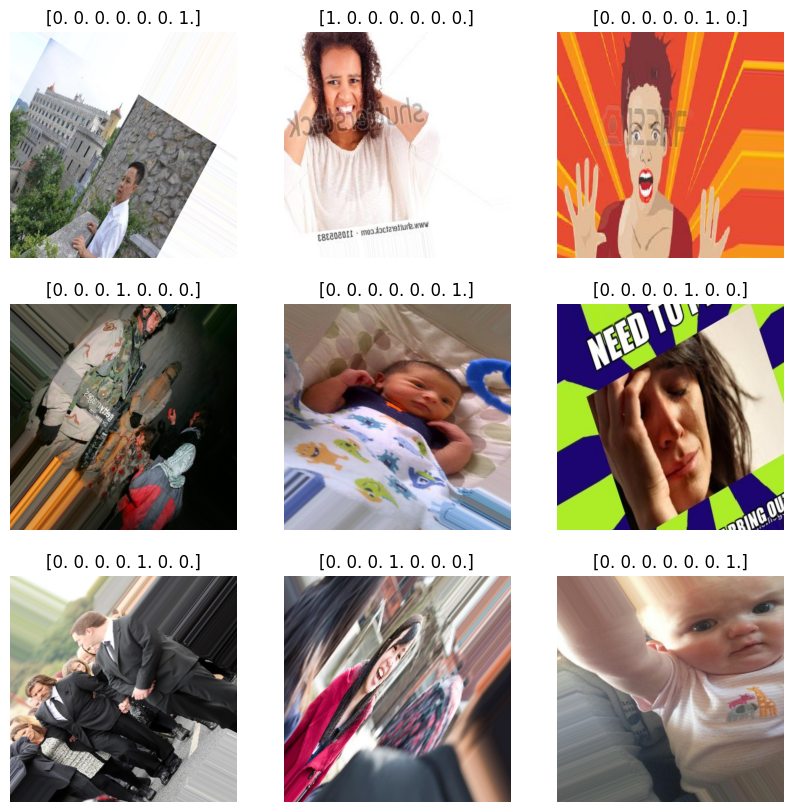

In [9]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.title(data[1][:9][i])
    plt.imshow(data[0][:9][i])
    plt.axis("off")
    

In [10]:
conv_base = VGG16(
    weights='imagenet',
    include_top = False,
    input_shape=(420,420,3)
)

In [11]:
conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
  if layer.name == 'block4_conv1':
    set_trainable = True
  if set_trainable:
    layer.trainable = True
  else:
    layer.trainable = False

for layer in conv_base.layers:
  print(layer.name,layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 True
block4_conv2 True
block4_conv3 True
block4_pool True
block5_conv1 True
block5_conv2 True
block5_conv3 True
block5_pool True


In [12]:
tf.function(experimental_relax_shapes=True)
# gpus = tf.config.experimental.list_physical_devices('GPU') 
# for gpu in gpus:
#     tf.config.experimental.set_memory_growth(gpu, True)
    
os.environ["CUDA_VISIBLE_DEVICES"]="0,1" #Num of your GPUs

mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


In [43]:
# with mirrored_strategy.scope():
model = Sequential()

model.add(Conv2D(64 , activation='LeakyReLU' ,kernel_size=(8,8) , kernel_regularizer=regularizers.l1(0.15) , input_shape=(420,420,3)))
model.add(Conv2D(64 , activation='LeakyReLU' ,kernel_size=(8,8) , kernel_regularizer=regularizers.l1(0.15)))
model.add(MaxPooling2D(pool_size=(3,3) , strides=2 , padding="valid"))

model.add(Conv2D(128 , activation='LeakyReLU' ,kernel_size=(12,12) ,  kernel_regularizer=regularizers.l1(0.125)))
model.add(Conv2D(128 , activation='LeakyReLU' ,kernel_size=(12,12) ,  kernel_regularizer=regularizers.l1(0.125)))
model.add(MaxPooling2D(pool_size=(3,3) , strides=2 , padding="valid"))

model.add(Conv2D(256 , activation='LeakyReLU' ,kernel_size=(12,12) ,  kernel_regularizer=regularizers.l1(0.125)))
model.add(Conv2D(256 , activation='LeakyReLU' ,kernel_size=(8,8) ,  kernel_regularizer=regularizers.l1(0.125)))
model.add(MaxPooling2D(pool_size=(2,2) , strides=2 , padding="valid"))

model.add(Conv2D(510 , activation='LeakyReLU' ,kernel_size=(8,8) ,  kernel_regularizer=regularizers.l1(0.1)))
model.add(Conv2D(510 , activation='LeakyReLU' ,kernel_size=(4,4) ,  kernel_regularizer=regularizers.l1(0.1)))
model.add(Conv2D(510 , activation='LeakyReLU' ,kernel_size=(4,4) ,  kernel_regularizer=regularizers.l1(0.1)))
model.add(MaxPooling2D(pool_size=(2,2) , strides=2 ))

model.add(Conv2D(510 , activation='LeakyReLU' ,kernel_size=(2,2) ,  kernel_regularizer=regularizers.l1(0.09)))
model.add(Conv2D(510 , activation='LeakyReLU' ,kernel_size=(2,2) ,  kernel_regularizer=regularizers.l1(0.09)))
model.add(MaxPooling2D(pool_size=(2,2) , strides=2 ))
model.add(BatchNormalization())
model.add(Flatten())

model.add(Dense(256,activation='LeakyReLU', kernel_regularizer=regularizers.l1(0.12)))
model.add(Dropout(rate=0.15))
model.add(BatchNormalization())

model.add(Dense(128,activation='LeakyReLU' , kernel_regularizer=regularizers.l1(0.12)))
model.add(BatchNormalization())
model.add(Dropout(rate=0.15))

model.add(Dense(64,activation='LeakyReLU' , kernel_regularizer=regularizers.l1(0.11)))
model.add(Dropout(rate=0.125))
model.add(BatchNormalization())


model.add(Dense(32,activation='LeakyReLU' , kernel_regularizer=regularizers.l1(0.1)))
model.add(Dropout(rate=0.12))

model.add(Dense(32,activation='LeakyReLU' , kernel_regularizer=regularizers.l1(0.1)))
model.add(BatchNormalization())
model.add(Dropout(rate=0.1))
model.add(Dense(32,activation='LeakyReLU' ))

model.add(Dense(7 , activation='softmax'))

In [44]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_81 (Conv2D)          (None, 413, 413, 64)      12352     
                                                                 
 conv2d_82 (Conv2D)          (None, 406, 406, 64)      262208    
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 202, 202, 64)      0         
 ng2D)                                                           
                                                                 
 conv2d_83 (Conv2D)          (None, 191, 191, 128)     1179776   
                                                                 
 conv2d_84 (Conv2D)          (None, 180, 180, 128)     2359424   
                                                                 
 max_pooling2d_34 (MaxPooli  (None, 89, 89, 128)       0         
 ng2D)                                                

In [45]:
run_opts = tf.compat.v1.RunOptions(report_tensor_allocations_upon_oom = True)
model.compile(optimizer='adam' , loss='categorical_crossentropy' , metrics=['accuracy'] ,jit_compile=run_opts)

In [36]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit_generator( train_data ,
                steps_per_epoch = 2000 //batch_size, epochs =50,
                validation_data = test_data, #change this
                validation_steps = 800 //batch_size)

/tmp/ipykernel_38702/111718400.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator( train_data ,


Epoch 1/5


2024-02-08 22:36:57.819676: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-02-08 22:37:02.097341: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-02-08 22:37:46.238701: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

2024-02-08 22:37:46.574443: E tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:114] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas be

  1/125 [..............................] - ETA: 3:24:55 - loss: 617.8437 - accuracy: 0.0000e+00

2024-02-08 22:38:07.628164: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 4627374080 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 0/8589410304
2024-02-08 22:38:07.628253: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                      5853151232
InUse:                      4951924248
MaxInUse:                   9617571336
NumAllocs:                      321990
MaxAllocSize:               4823261200
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-02-08 22:38:07.628299: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:63] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2024-02-08 22:38:07.628305: E tensorflow/compiler/xla/stream_executor/gpu/

 28/125 [=====>........................] - ETA: 8:39 - loss: 459.5626 - accuracy: 0.1272

2024-02-08 22:40:33.580415: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 4627374080 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 0/8589410304
2024-02-08 22:40:33.580482: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                      5853151232
InUse:                      4951924248
MaxInUse:                   9617571336
NumAllocs:                      332762
MaxAllocSize:               4823261200
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-02-08 22:40:33.580534: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:63] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2024-02-08 22:40:33.580538: E tensorflow/compiler/xla/stream_executor/gpu/

 54/125 [===========>..................] - ETA: 6:13 - loss: 341.9164 - accuracy: 0.1725

2024-02-08 22:42:47.527599: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 4627374080 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 0/8589410304
2024-02-08 22:42:47.527682: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                      5853151232
InUse:                      4951924248
MaxInUse:                   9617571336
NumAllocs:                      343135
MaxAllocSize:               4823261200
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-02-08 22:42:47.527723: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:63] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2024-02-08 22:42:47.527729: E tensorflow/compiler/xla/stream_executor/gpu/

 80/125 [==================>...........] - ETA: 3:54 - loss: 267.8254 - accuracy: 0.2141

2024-02-08 22:45:01.540842: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 4627374080 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 0/8589410304
2024-02-08 22:45:01.540935: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                      5853151232
InUse:                      4951924248
MaxInUse:                   9617571336
NumAllocs:                      353508
MaxAllocSize:               4823261200
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-02-08 22:45:01.540974: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:63] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2024-02-08 22:45:01.540979: E tensorflow/compiler/xla/stream_executor/gpu/

103/125 [=======================>......] - ETA: 1:57 - loss: 222.1538 - accuracy: 0.2251

2024-02-08 22:47:15.630239: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 4627374080 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 0/8589410304
2024-02-08 22:47:15.630826: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                      5853151232
InUse:                      4951924248
MaxInUse:                   9617571336
NumAllocs:                      362684
MaxAllocSize:               4823261200
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-02-08 22:47:15.630902: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:63] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2024-02-08 22:47:15.630909: E tensorflow/compiler/xla/stream_executor/gpu/

121/125 [============================>.] - ETA: 22s - loss: 194.8901 - accuracy: 0.2355

2024-02-08 22:49:35.294589: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 4627374080 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 0/8589410304
2024-02-08 22:49:35.294655: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                      5853151232
InUse:                      4951924248
MaxInUse:                   9617571336
NumAllocs:                      369865
MaxAllocSize:               4823261200
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-02-08 22:49:35.294690: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:63] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2024-02-08 22:49:35.294695: E tensorflow/compiler/xla/stream_executor/gpu/

125/125 [==============================] - 875s 6s/step - loss: 189.6186 - accuracy: 0.2405 - val_loss: 29.1564 - val_accuracy: 0.1538
Epoch 2/5
  9/125 [=>............................] - ETA: 8:47 - loss: 27.2546 - accuracy: 0.2708

2024-02-08 22:51:45.863483: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 4627374080 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 0/8589410304
2024-02-08 22:51:45.863613: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                      5853151232
InUse:                      4951924292
MaxInUse:                   9617571336
NumAllocs:                      381152
MaxAllocSize:               4853800976
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-02-08 22:51:45.863662: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:63] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2024-02-08 22:51:45.863668: E tensorflow/compiler/xla/stream_executor/gpu/

 32/125 [======>.......................] - ETA: 9:23 - loss: 22.5258 - accuracy: 0.3105

2024-02-08 22:54:26.291395: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 4627374080 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 0/8589410304
2024-02-08 22:54:26.291483: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                      5853151232
InUse:                      4951924292
MaxInUse:                   9617571336
NumAllocs:                      390328
MaxAllocSize:               4853800976
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-02-08 22:54:26.291523: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:63] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2024-02-08 22:54:26.291530: E tensorflow/compiler/xla/stream_executor/gpu/

 58/125 [============>.................] - ETA: 6:30 - loss: 18.6264 - accuracy: 0.3233

2024-02-08 22:56:41.491146: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 4627374080 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 0/8589410304
2024-02-08 22:56:41.491884: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                      5853151232
InUse:                      4951924292
MaxInUse:                   9617571336
NumAllocs:                      400701
MaxAllocSize:               4853800976
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-02-08 22:56:41.492189: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:63] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2024-02-08 22:56:41.492198: E tensorflow/compiler/xla/stream_executor/gpu/

 78/125 [=================>............] - ETA: 4:42 - loss: 16.3016 - accuracy: 0.3357

2024-02-08 22:58:52.237578: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 4627374080 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 0/8589410304
2024-02-08 22:58:52.237659: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                      5853151232
InUse:                      4951924292
MaxInUse:                   9617571336
NumAllocs:                      408680
MaxAllocSize:               4853800976
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-02-08 22:58:52.237698: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:63] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2024-02-08 22:58:52.237705: E tensorflow/compiler/xla/stream_executor/gpu/

104/125 [=======================>......] - ETA: 2:01 - loss: 13.9265 - accuracy: 0.3335

2024-02-08 23:01:05.285455: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 4627374080 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 0/8589410304
2024-02-08 23:01:05.285533: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                      5853151232
InUse:                      4951924292
MaxInUse:                   9617571336
NumAllocs:                      419053
MaxAllocSize:               4853800976
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-02-08 23:01:05.285583: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:63] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2024-02-08 23:01:05.285588: E tensorflow/compiler/xla/stream_executor/gpu/

125/125 [==============================] - 744s 6s/step - loss: 12.3795 - accuracy: 0.3345 - val_loss: 4.5306 - val_accuracy: 0.1425
Epoch 3/5


2024-02-08 23:03:28.298048: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 4627374080 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 0/8589410304
2024-02-08 23:03:28.298121: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                      5853151232
InUse:                      4951924292
MaxInUse:                   9617571336
NumAllocs:                      433244
MaxAllocSize:               4853800976
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-02-08 23:03:28.298156: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:63] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2024-02-08 23:03:28.298161: E tensorflow/compiler/xla/stream_executor/gpu/

 26/125 [=====>........................] - ETA: 9:16 - loss: 3.3898 - accuracy: 0.3798

2024-02-08 23:05:59.014414: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 4627374080 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 0/8589410304
2024-02-08 23:05:59.014481: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                      5853151232
InUse:                      4951924292
MaxInUse:                   9617571336
NumAllocs:                      443617
MaxAllocSize:               4853800976
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-02-08 23:05:59.014512: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:63] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2024-02-08 23:05:59.014517: E tensorflow/compiler/xla/stream_executor/gpu/

 52/125 [===========>..................] - ETA: 6:34 - loss: 3.0188 - accuracy: 0.3618

2024-02-08 23:08:13.238161: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 4627374080 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 0/8589410304
2024-02-08 23:08:13.238229: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                      5853151232
InUse:                      4951924292
MaxInUse:                   9617571336
NumAllocs:                      453990
MaxAllocSize:               4853800976
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-02-08 23:08:13.238265: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:63] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2024-02-08 23:08:13.238272: E tensorflow/compiler/xla/stream_executor/gpu/

 77/125 [=================>............] - ETA: 4:17 - loss: 2.7588 - accuracy: 0.3709

2024-02-08 23:10:25.913394: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 4627374080 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 0/8589410304
2024-02-08 23:10:25.913484: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                      5853151232
InUse:                      4951924292
MaxInUse:                   9617571336
NumAllocs:                      463964
MaxAllocSize:               4853800976
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-02-08 23:10:25.913522: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:63] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2024-02-08 23:10:25.913528: E tensorflow/compiler/xla/stream_executor/gpu/

 95/125 [=====================>........] - ETA: 2:52 - loss: 2.6405 - accuracy: 0.3678

2024-02-08 23:12:37.862224: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 4627374080 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 0/8589410304
2024-02-08 23:12:37.862702: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                      5853151232
InUse:                      4951924292
MaxInUse:                   9617571336
NumAllocs:                      471145
MaxAllocSize:               4853800976
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-02-08 23:12:37.862762: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:63] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2024-02-08 23:12:37.862771: E tensorflow/compiler/xla/stream_executor/gpu/

121/125 [============================>.] - ETA: 22s - loss: 2.4983 - accuracy: 0.3693

2024-02-08 23:14:48.909713: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 4627374080 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 0/8589410304
2024-02-08 23:14:48.909789: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                      5853151232
InUse:                      4951924292
MaxInUse:                   9617571336
NumAllocs:                      481518
MaxAllocSize:               4853800976
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-02-08 23:14:48.909821: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:63] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2024-02-08 23:14:48.909826: E tensorflow/compiler/xla/stream_executor/gpu/

125/125 [==============================] - 739s 6s/step - loss: 2.4808 - accuracy: 0.3710 - val_loss: 2.8241 - val_accuracy: 0.1375
Epoch 4/5
 17/125 [===>..........................] - ETA: 7:57 - loss: 1.9407 - accuracy: 0.3971

2024-02-08 23:17:01.944085: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 4627374080 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 0/8589410304
2024-02-08 23:17:01.944226: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                      5853151232
InUse:                      4951924292
MaxInUse:                   9617571336
NumAllocs:                      495709
MaxAllocSize:               4853800976
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-02-08 23:17:01.944287: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:63] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2024-02-08 23:17:01.944293: E tensorflow/compiler/xla/stream_executor/gpu/

 41/125 [========>.....................] - ETA: 7:11 - loss: 1.9705 - accuracy: 0.4024

2024-02-08 23:19:18.384424: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 4627374080 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 0/8589410304
2024-02-08 23:19:18.384502: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                      5853151232
InUse:                      4951924292
MaxInUse:                   9617571336
NumAllocs:                      505284
MaxAllocSize:               4853800976
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-02-08 23:19:18.384545: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:63] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2024-02-08 23:19:18.384551: E tensorflow/compiler/xla/stream_executor/gpu/

 60/125 [=============>................] - ETA: 6:13 - loss: 1.9748 - accuracy: 0.3865

2024-02-08 23:21:30.242499: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 4627374080 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 0/8589410304
2024-02-08 23:21:30.242626: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                      5853151232
InUse:                      4951924292
MaxInUse:                   9617571336
NumAllocs:                      512864
MaxAllocSize:               4853800976
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-02-08 23:21:30.242675: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:63] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2024-02-08 23:21:30.242681: E tensorflow/compiler/xla/stream_executor/gpu/

 81/125 [==================>...........] - ETA: 4:19 - loss: 1.9852 - accuracy: 0.3688

2024-02-08 23:23:43.106230: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 4627374080 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 0/8589410304
2024-02-08 23:23:43.106301: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                      5853151232
InUse:                      4951924292
MaxInUse:                   9617571336
NumAllocs:                      521242
MaxAllocSize:               4853800976
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-02-08 23:23:43.106333: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:63] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2024-02-08 23:23:43.106338: E tensorflow/compiler/xla/stream_executor/gpu/

106/125 [========================>.....] - ETA: 1:49 - loss: 1.9783 - accuracy: 0.3721

2024-02-08 23:25:54.926291: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 4627374080 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 0/8589410304
2024-02-08 23:25:54.926349: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                      5853151232
InUse:                      4951924292
MaxInUse:                   9617571336
NumAllocs:                      531216
MaxAllocSize:               4853800976
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-02-08 23:25:54.926379: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:63] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2024-02-08 23:25:54.926384: E tensorflow/compiler/xla/stream_executor/gpu/

125/125 [==============================] - 727s 6s/step - loss: 1.9772 - accuracy: 0.3750 - val_loss: 2.8552 - val_accuracy: 0.1500
Epoch 5/5
  2/125 [..............................] - ETA: 9:47 - loss: 1.9845 - accuracy: 0.3750 

2024-02-08 23:28:08.063551: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 4627374080 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 0/8589410304
2024-02-08 23:28:08.064109: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                      5853151232
InUse:                      4951924292
MaxInUse:                   9617571336
NumAllocs:                      545407
MaxAllocSize:               4853800976
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-02-08 23:28:08.064253: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:63] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2024-02-08 23:28:08.064265: E tensorflow/compiler/xla/stream_executor/gpu/

 28/125 [=====>........................] - ETA: 9:01 - loss: 1.9756 - accuracy: 0.3728

2024-02-08 23:30:41.058714: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 4627374080 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 0/8589410304
2024-02-08 23:30:41.058773: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                      5853151232
InUse:                      4951924292
MaxInUse:                   9617571336
NumAllocs:                      555780
MaxAllocSize:               4853800976
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-02-08 23:30:41.058802: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:63] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2024-02-08 23:30:41.058807: E tensorflow/compiler/xla/stream_executor/gpu/

 55/125 [============>.................] - ETA: 6:17 - loss: 1.9655 - accuracy: 0.4011

2024-02-08 23:32:53.256373: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 4627374080 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 0/8589410304
2024-02-08 23:32:53.256467: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                      5853151232
InUse:                      4951924292
MaxInUse:                   9617571336
NumAllocs:                      566552
MaxAllocSize:               4853800976
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-02-08 23:32:53.256507: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:63] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2024-02-08 23:32:53.256514: E tensorflow/compiler/xla/stream_executor/gpu/

 77/125 [=================>............] - ETA: 4:27 - loss: 1.9878 - accuracy: 0.3880

2024-02-08 23:35:05.205204: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 4627374080 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 0/8589410304
2024-02-08 23:35:05.205319: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                      5853151232
InUse:                      4951924292
MaxInUse:                   9617571336
NumAllocs:                      575329
MaxAllocSize:               4853800976
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-02-08 23:35:05.205358: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:63] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2024-02-08 23:35:05.205365: E tensorflow/compiler/xla/stream_executor/gpu/

102/125 [=======================>......] - ETA: 2:06 - loss: 1.9749 - accuracy: 0.3879

2024-02-08 23:37:18.598544: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:306] gpu_async_0 cuMemAllocAsync failed to allocate 4627374080 bytes: CUDA error: out of memory (CUDA_ERROR_OUT_OF_MEMORY)
 Reported by CUDA: Free memory/Total memory: 0/8589410304
2024-02-08 23:37:18.598626: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:311] Stats: Limit:                      5853151232
InUse:                      4951924292
MaxInUse:                   9617571336
NumAllocs:                      585303
MaxAllocSize:               4853800976
Reserved:                            0
PeakReserved:                        0
LargestFreeBlock:                    0

2024-02-08 23:37:18.598660: E tensorflow/compiler/xla/stream_executor/gpu/gpu_cudamallocasync_allocator.cc:63] Histogram of current allocation: (allocation_size_in_bytes, nb_allocation_of_that_sizes), ...;
2024-02-08 23:37:18.598665: E tensorflow/compiler/xla/stream_executor/gpu/

125/125 [==============================] - 720s 6s/step - loss: 1.9811 - accuracy: 0.3880 - val_loss: 2.8179 - val_accuracy: 0.1500


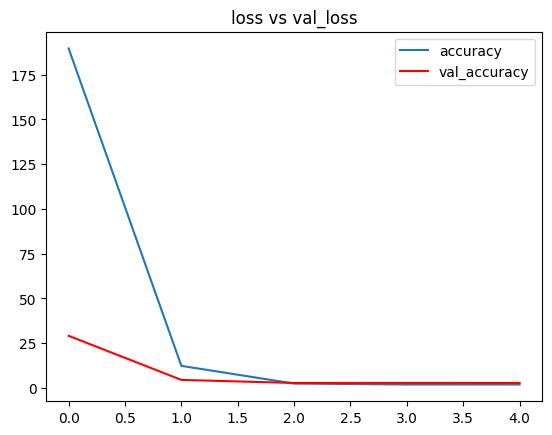

In [37]:
plt.plot(history.history['loss']  ,label='accuracy')
plt.plot(history.history['val_loss'] , 'red' ,label='val_accuracy')
plt.title('loss vs val_loss')
plt.legend()

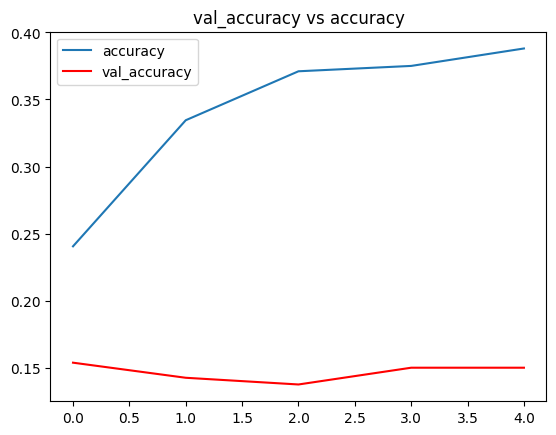

In [38]:
plt.plot(history.history['accuracy']  ,label='accuracy')
plt.plot(history.history['val_accuracy'] , 'red' ,label='val_accuracy')
plt.title('val_accuracy vs accuracy')
plt.legend()

In [ ]:
pickle.dump(model , open('mode_vgg_update_v1.pkl' , 'wb'))

In [ ]:
model = pickle.load( open('mode_vgg_update_v1.pkl' , 'rb'))

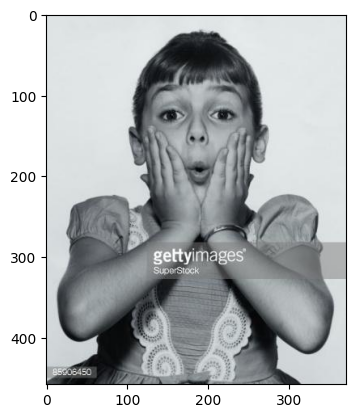

In [39]:
Image = cv2.imread('amazed_people_182.jpg')
plt.imshow(Image)

In [40]:
Image = cv2.resize(Image,(420,420))
output = model.predict(Image.reshape((1,420,420,3)))
output

1/1 [==============================] - 2s 2s/step


array([[0.04608228, 0.05481986, 0.01651689, 0.28722432, 0.13863358,
        0.0765726 , 0.38015053]], dtype=float32)

In [41]:
output.max()

0.38015053

In [42]:
decode = {
    0 : "angry",
    1 : "disgust",
    2 : "fear",
    3 : "happy",
    4 : "sad",
    5 : "surprise",
    6 : "neutral",
}
for key , value in decode.items():
    if np.where(output==output.max())[1] == key:
        print(value)

neutral
